In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from models import *
from create_plots import *
from utils import AmericanPutData, get_prices_put
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Put Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [2]:
put_data = AmericanPutData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = put_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=False)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_put(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_put.csv")

(10000, 8)


In [2]:
df = pd.read_csv("../train_data/generated_put.csv", index_col=0)
df.head()

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,827.0,138.66,39.12,133.0,-0.876502,0.052474,-4.578248,15.334991,0.00
1,1045.0,113.58,45.38,228.0,-0.118852,0.002001,-7.851140,3.742773,6.48
2,395.0,194.28,27.86,937.0,-0.756109,0.000596,-1.044538,0.431675,0.00
3,563.0,112.40,45.66,109.0,-0.196355,0.012452,-4.211471,12.599267,7.64
4,980.0,145.38,37.53,72.0,-0.417402,0.012488,-0.112282,7.536177,0.00


Describe:
count    10000.000000
mean        38.778089
std         32.927976
min          0.000000
25%          0.000000
50%         37.310000
75%         55.310000
max        120.000000
Name: TargetPrice, dtype: float64

Skewness: 0.7879415236679352
Kurtosis: 0.4289552629526088


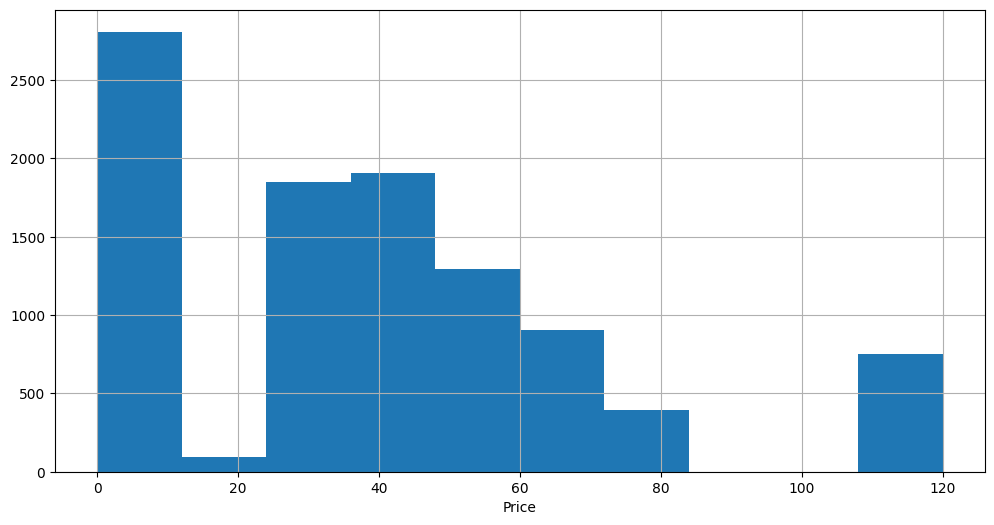

In [9]:
analyze_series(df.TargetPrice)

In [4]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice < K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice >= K)}")

ITM count:4272
OTM count:5728


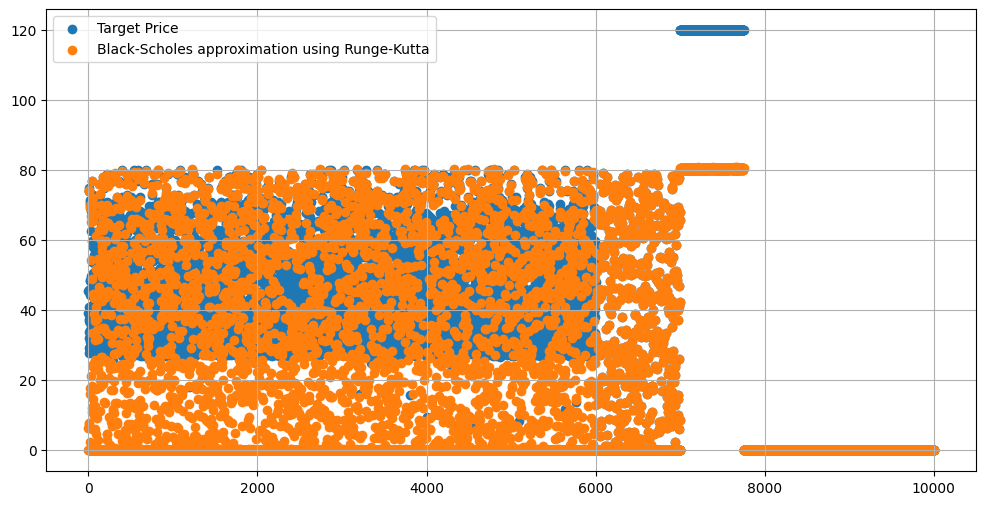

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="Target Price"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="Black-Scholes approximation using Runge-Kutta")
plt.legend()
plt.grid(True)
plt.show()

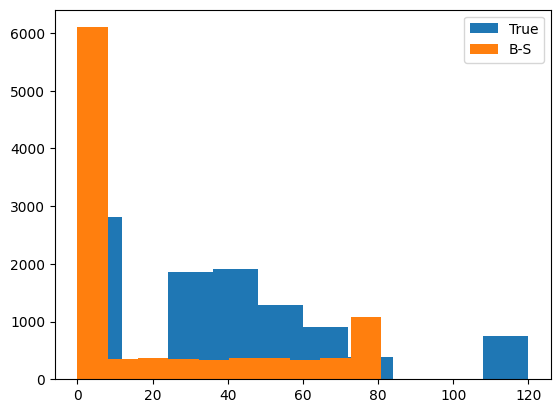

In [6]:
plt.hist(df.TargetPrice, label="True")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [4]:
# # adding BSAprox column to real data
# # Run it once, only if u dont have saved df
# df_real = pd.read_csv("../train_data/put_df.csv", index_col=0)
# df_real = get_prices_put(df_real.to_numpy(), generated=False)
# df_real = pd.DataFrame(
#     data=df_real,
#     columns=[
#         [
#             "UnderlyingPrice",
#             "Type",
#             "Strike",
#             "OpenInterest",
#             "IV",
#             "Delta",
#             "Gamma",
#             "Theta",
#             "Vega",
#             "Time",
#             "TargetPrice",
#             "BSAprox",
#         ]
#     ],
# )
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/put_df_with_approx.csv")
# df_real.head()

In [7]:
df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,put,55.0,22,0.3314,-0.0004,0.0003,-0.0747,0.0253,21,0.02,0.0
1,71.11,put,60.0,118,0.3314,-0.0130,0.0060,-1.6451,0.5604,21,0.04,0.0
2,71.11,put,62.5,2026,0.3314,-0.0441,0.0168,-4.5773,1.5638,21,0.11,0.0
3,71.11,put,65.0,443,0.2918,-0.0873,0.0324,-6.8317,2.6647,21,0.20,0.0
4,71.11,put,67.5,165,0.2675,-0.1902,0.0605,-10.6215,4.5580,21,0.48,0.0


Describe:
count    223217.000000
mean          9.203034
std          20.484802
min           0.000000
25%           0.000000
50%           0.000000
75%          10.390000
max         600.720000
Name: BSAprox, dtype: float64

Skewness: 6.657008389112579
Kurtosis: 90.22743557230235


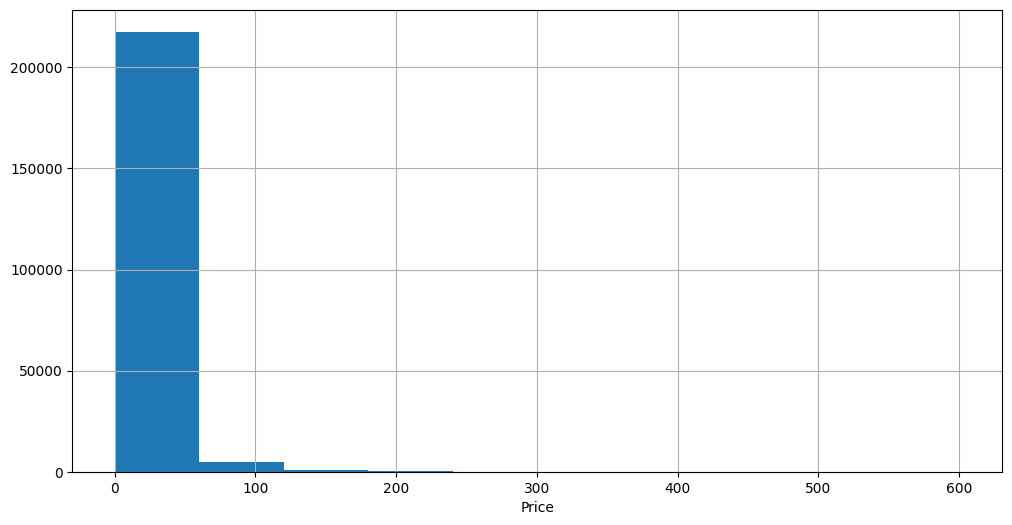

In [8]:
analyze_series(df_real.BSAprox)

In [3]:

# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.000563403
HIDDEN_LAYER = 26
HIDDEN_WIDTH = 84
EXPERIMENT_NAME = "exp_put_10_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [5]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [20]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
# df = df_real.sample(n=20000, random_state=15)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


Describe:
count    16000.000000
mean         1.623540
std          6.854486
min       -600.230000
25%          0.120000
50%          0.550000
75%          1.980000
max         52.280000
dtype: float64

Skewness: -59.412366376729324
Kurtosis: 4889.175253597014
Describe:
count    4000.000000
mean        1.725048
std         3.616202
min        -9.390000
25%         0.110000
50%         0.520000
75%         1.922500
max        58.620000
dtype: float64

Skewness: 6.062906189980081
Kurtosis: 57.795717636589806


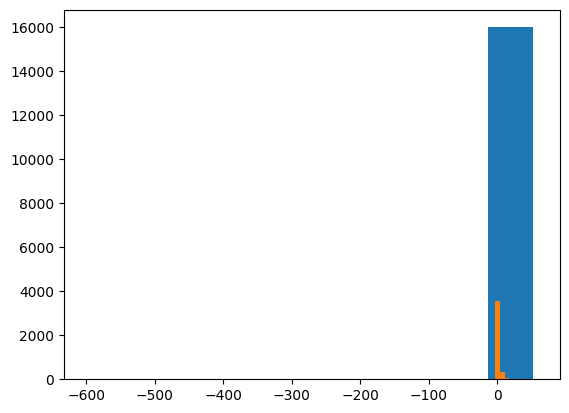

In [8]:
analyze_series(df_train.TargetPrice-df_train.BSAprox)
analyze_series(df_val.TargetPrice-df_val.BSAprox)

In [22]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [23]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [28]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )

In [29]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 63/63 [00:00<00:00, 332.25it/s]

Epoch 1, train loss: 314.8535, val loss: 328.7069



100%|██████████| 63/63 [00:00<00:00, 195.37it/s]

Epoch 2, train loss: 330.9773, val loss: 338.3005



100%|██████████| 63/63 [00:00<00:00, 277.09it/s]

Epoch 3, train loss: 333.9703, val loss: 341.7280



100%|██████████| 63/63 [00:00<00:00, 285.98it/s]

Epoch 4, train loss: 339.6174, val loss: 341.1055



100%|██████████| 63/63 [00:00<00:00, 291.81it/s]

Epoch 5, train loss: 336.2130, val loss: 341.3618



100%|██████████| 63/63 [00:00<00:00, 291.17it/s]

Epoch 6, train loss: 338.4899, val loss: 338.2401



100%|██████████| 63/63 [00:00<00:00, 298.59it/s]

Epoch 7, train loss: 332.4748, val loss: 335.9918



100%|██████████| 63/63 [00:00<00:00, 293.70it/s]

Epoch 8, train loss: 333.5048, val loss: 332.5041



100%|██████████| 63/63 [00:00<00:00, 290.47it/s]

Epoch 9, train loss: 335.0490, val loss: 335.6137



100%|██████████| 63/63 [00:00<00:00, 298.44it/s]

Epoch 10, train loss: 337.6443, val loss: 333.0590



100%|██████████| 63/63 [00:00<00:00, 314.15it/s]

Epoch 11, train loss: 337.6916, val loss: 329.0711



100%|██████████| 63/63 [00:00<00:00, 294.33it/s]

Epoch 12, train loss: 335.4176, val loss: 331.5302



100%|██████████| 63/63 [00:00<00:00, 286.78it/s]

Epoch 13, train loss: 334.9241, val loss: 335.7816



100%|██████████| 63/63 [00:00<00:00, 228.58it/s]

Epoch 14, train loss: 334.9169, val loss: 339.2633



100%|██████████| 63/63 [00:00<00:00, 293.89it/s]

Epoch 15, train loss: 334.7792, val loss: 329.9856



100%|██████████| 63/63 [00:00<00:00, 256.42it/s]

Epoch 16, train loss: 331.8317, val loss: 338.1167



100%|██████████| 63/63 [00:00<00:00, 275.87it/s]

Epoch 17, train loss: 334.2771, val loss: 340.8485



100%|██████████| 63/63 [00:00<00:00, 259.58it/s]

Epoch 18, train loss: 333.1749, val loss: 337.9039



100%|██████████| 63/63 [00:00<00:00, 273.32it/s]

Epoch 19, train loss: 330.3219, val loss: 340.7028



100%|██████████| 63/63 [00:00<00:00, 294.16it/s]

Epoch 20, train loss: 328.9866, val loss: 340.1187
Optimizer: RMSprop



100%|██████████| 63/63 [00:00<00:00, 296.84it/s]

Epoch 1, train loss: 332.4873, val loss: 337.3228



100%|██████████| 63/63 [00:00<00:00, 304.48it/s]

Epoch 2, train loss: 327.2724, val loss: 336.8241



100%|██████████| 63/63 [00:00<00:00, 297.92it/s]

Epoch 3, train loss: 323.7130, val loss: 334.0879



100%|██████████| 63/63 [00:00<00:00, 271.26it/s]

Epoch 4, train loss: 320.2161, val loss: 334.6773



100%|██████████| 63/63 [00:00<00:00, 295.00it/s]

Epoch 5, train loss: 316.9580, val loss: 330.6693



100%|██████████| 63/63 [00:00<00:00, 297.86it/s]

Epoch 6, train loss: 315.5954, val loss: 330.8189



100%|██████████| 63/63 [00:00<00:00, 309.54it/s]

Epoch 7, train loss: 314.1399, val loss: 330.4351



100%|██████████| 63/63 [00:00<00:00, 300.50it/s]

Epoch 8, train loss: 311.0752, val loss: 329.8064



100%|██████████| 63/63 [00:00<00:00, 298.26it/s]

Epoch 9, train loss: 307.0093, val loss: 329.6853



100%|██████████| 63/63 [00:00<00:00, 300.75it/s]

Epoch 10, train loss: 304.0529, val loss: 328.2680



100%|██████████| 63/63 [00:00<00:00, 287.38it/s]

Epoch 11, train loss: 301.9211, val loss: 330.5697



100%|██████████| 63/63 [00:00<00:00, 305.69it/s]

Epoch 12, train loss: 299.7335, val loss: 331.4938



100%|██████████| 63/63 [00:00<00:00, 293.71it/s]

Epoch 13, train loss: 296.8740, val loss: 326.8566



100%|██████████| 63/63 [00:00<00:00, 291.46it/s]

Epoch 14, train loss: 295.3045, val loss: 326.9454



100%|██████████| 63/63 [00:00<00:00, 310.38it/s]

Epoch 15, train loss: 292.6271, val loss: 325.3416



100%|██████████| 63/63 [00:00<00:00, 306.03it/s]

Epoch 16, train loss: 290.3988, val loss: 326.9995



100%|██████████| 63/63 [00:00<00:00, 299.71it/s]

Epoch 17, train loss: 288.0839, val loss: 328.3495



100%|██████████| 63/63 [00:00<00:00, 259.63it/s]

Epoch 18, train loss: 285.9204, val loss: 326.6470



100%|██████████| 63/63 [00:00<00:00, 246.54it/s]

Epoch 19, train loss: 283.9292, val loss: 327.1714



100%|██████████| 63/63 [00:00<00:00, 272.55it/s]

Epoch 20, train loss: 283.2352, val loss: 326.5110
Optimizer: Adam



100%|██████████| 63/63 [00:00<00:00, 255.93it/s]

Epoch 1, train loss: 295.5237, val loss: 330.0242



100%|██████████| 63/63 [00:00<00:00, 296.54it/s]

Epoch 2, train loss: 302.4229, val loss: 330.6104



100%|██████████| 63/63 [00:00<00:00, 281.58it/s]

Epoch 3, train loss: 303.0155, val loss: 327.3952



100%|██████████| 63/63 [00:00<00:00, 300.81it/s]

Epoch 4, train loss: 300.9198, val loss: 328.0634



100%|██████████| 63/63 [00:00<00:00, 239.57it/s]

Epoch 5, train loss: 301.8804, val loss: 331.8340



100%|██████████| 63/63 [00:00<00:00, 272.57it/s]

Epoch 6, train loss: 300.9548, val loss: 328.0657



100%|██████████| 63/63 [00:00<00:00, 236.79it/s]

Epoch 7, train loss: 300.2825, val loss: 328.6774



100%|██████████| 63/63 [00:00<00:00, 269.91it/s]

Epoch 8, train loss: 297.9354, val loss: 329.0555



100%|██████████| 63/63 [00:00<00:00, 301.96it/s]

Epoch 9, train loss: 296.3738, val loss: 328.1228



100%|██████████| 63/63 [00:00<00:00, 288.23it/s]

Epoch 10, train loss: 294.9309, val loss: 327.5884



100%|██████████| 63/63 [00:00<00:00, 311.08it/s]

Epoch 11, train loss: 292.8128, val loss: 327.5550



100%|██████████| 63/63 [00:00<00:00, 292.40it/s]

Epoch 12, train loss: 290.2075, val loss: 327.1901



100%|██████████| 63/63 [00:00<00:00, 275.74it/s]

Epoch 13, train loss: 287.4568, val loss: 330.0776



100%|██████████| 63/63 [00:00<00:00, 300.83it/s]

Epoch 14, train loss: 286.0533, val loss: 327.0832



100%|██████████| 63/63 [00:00<00:00, 289.87it/s]

Epoch 15, train loss: 283.8678, val loss: 328.0234



100%|██████████| 63/63 [00:00<00:00, 301.38it/s]

Epoch 16, train loss: 281.6557, val loss: 329.3657



100%|██████████| 63/63 [00:00<00:00, 292.50it/s]

Epoch 17, train loss: 280.1070, val loss: 329.2153



100%|██████████| 63/63 [00:00<00:00, 300.80it/s]

Epoch 18, train loss: 278.9489, val loss: 329.3311



100%|██████████| 63/63 [00:00<00:00, 292.39it/s]

Epoch 19, train loss: 277.7179, val loss: 329.3069



100%|██████████| 63/63 [00:00<00:00, 263.31it/s]

Epoch 20, train loss: 277.0980, val loss: 329.2078
Optimizer: Adamax



100%|██████████| 63/63 [00:00<00:00, 292.75it/s]

Epoch 1, train loss: 279.9969, val loss: 328.5661



100%|██████████| 63/63 [00:00<00:00, 286.27it/s]

Epoch 2, train loss: 278.9691, val loss: 329.2951



100%|██████████| 63/63 [00:00<00:00, 288.03it/s]

Epoch 3, train loss: 277.5203, val loss: 329.2003



100%|██████████| 63/63 [00:00<00:00, 300.14it/s]

Epoch 4, train loss: 275.5428, val loss: 329.4946



100%|██████████| 63/63 [00:00<00:00, 294.60it/s]

Epoch 5, train loss: 274.5540, val loss: 329.6378



100%|██████████| 63/63 [00:00<00:00, 288.93it/s]

Epoch 6, train loss: 272.9183, val loss: 330.0295



100%|██████████| 63/63 [00:00<00:00, 302.72it/s]

Epoch 7, train loss: 271.5502, val loss: 331.3682



100%|██████████| 63/63 [00:00<00:00, 306.77it/s]

Epoch 8, train loss: 269.6922, val loss: 328.3273



100%|██████████| 63/63 [00:00<00:00, 291.77it/s]

Epoch 9, train loss: 268.1737, val loss: 328.5008



100%|██████████| 63/63 [00:00<00:00, 289.27it/s]

Epoch 10, train loss: 267.0907, val loss: 331.7504



100%|██████████| 63/63 [00:00<00:00, 295.13it/s]

Epoch 11, train loss: 266.5205, val loss: 330.4008



100%|██████████| 63/63 [00:00<00:00, 303.72it/s]

Epoch 12, train loss: 264.6225, val loss: 330.4865



100%|██████████| 63/63 [00:00<00:00, 284.71it/s]

Epoch 13, train loss: 263.7040, val loss: 330.9823



100%|██████████| 63/63 [00:00<00:00, 305.48it/s]

Epoch 14, train loss: 262.4122, val loss: 330.8162



100%|██████████| 63/63 [00:00<00:00, 292.71it/s]

Epoch 15, train loss: 261.5891, val loss: 330.6774



100%|██████████| 63/63 [00:00<00:00, 285.86it/s]

Epoch 16, train loss: 261.1606, val loss: 330.4286



100%|██████████| 63/63 [00:00<00:00, 299.24it/s]

Epoch 17, train loss: 260.1071, val loss: 330.0126



100%|██████████| 63/63 [00:00<00:00, 281.84it/s]

Epoch 18, train loss: 259.3287, val loss: 330.3075



100%|██████████| 63/63 [00:00<00:00, 292.96it/s]

Epoch 19, train loss: 258.7729, val loss: 330.7462



100%|██████████| 63/63 [00:00<00:00, 288.72it/s]

Epoch 20, train loss: 258.5283, val loss: 330.5176


In [16]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import optuna
from optuna.trial import TrialState
from tqdm import tqdm


# Define the model
class AmericanPut_gated3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(AmericanPut_gated3, self).__init__()
        self.N_HIDDEN = N_HIDDEN
        self.activation1 = nn.LeakyReLU(negative_slope=0.2)
        self.activation2 = nn.Tanh()
        self.fcs1 = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), self.activation2)
        self.fcs2 = nn.Sequential(nn.Linear(N_INPUT, N_OUTPUT), self.activation2)
        self.fch = nn.Sequential(
            *[
                nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), self.activation2)
                for _ in range(N_LAYERS)
            ]
        )
        self.fce = nn.Sequential(*[nn.Linear(N_HIDDEN, N_OUTPUT)])
        self.w1_layer = nn.Sequential(
            *[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT), self.activation2]
        )
        # self.w2_layer = nn.Sequential(*[nn.Linear(N_HIDDEN + N_INPUT, N_OUTPUT),self.activation2])

    def forward(self, x):
        # Apply the first layer
        I1 = self.fcs1(x)
        H = I1
        # Apply hidden layers with residual connections
        for layer in self.fch:
            H = layer(H) + H
        # Apply the final layer
        yx = self.fcs2(x)  # 1D
        yh = self.fce(H)  # 1D
        h_x = torch.cat([H, x], axis=1)
        # print (h_x.shape)
        wh = self.w1_layer(h_x)
        y_net = yx + wh * yh
        return y_net


# Objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_width = trial.suggest_int("hidden_width", 32, 128)
    hidden_layers = trial.suggest_int("hidden_layers", 10, 30)
    learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["SGD", "RMSprop", "Adam", "Adamax"]
    )
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # Create the model
    model = AmericanPut_gated3(5, 1, hidden_width, hidden_layers).to(DEVICE)

    # Create the optimizer
    optimizers_list = {
        "SGD": torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.7),
        "RMSprop": torch.optim.RMSprop(model.parameters(), lr=learning_rate),
        "Adam": torch.optim.Adam(model.parameters(), lr=learning_rate),
        "Adamax": torch.optim.Adamax(
            model.parameters(), lr=learning_rate, betas=(0.9, 0.99)
        ),
    }
    optimizer = optimizers_list[optimizer_name]

    # Define the ReduceLROnPlateau scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)
    # scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    criteriation = nn.MSELoss()

    # Create the dataloaders
    train_dataloader = DataLoader(
        train_df, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_df, batch_size=batch_size, shuffle=False, num_workers=8
    )

    # Training loop
    N_EPOCH = 10  # or some other number of epochs
    for epoch in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)

        # Report intermediate results to Optuna
        trial.report(val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss


# Run the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=600)

pruned_trials = [t for t in study.trials if t.state == TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == TrialState.COMPLETE]

print(f"Study statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

print(f"Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")

print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Use the best hyperparameters to train your final model
best_hidden_width = trial.params["hidden_width"]
best_hidden_layers = trial.params["hidden_layers"]
best_learning_rate = trial.params["learning_rate"]
best_optimizer_name = trial.params["optimizer"]
best_batch_size = trial.params["batch_size"]

[I 2024-06-01 18:28:44,063] A new study created in memory with name: no-name-5ea9fe14-92ce-4da3-8a81-112fab849810
/tmp/ipykernel_3907/609066327.py:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 2e-8, 1e-1)
100%|██████████| 32/32 [00:00<00:00, 311.35it/s]
[I 2024-06-01 18:28:56,697] Trial 0 finished with value: 283.4418511390686 and parameters: {'hidden_width': 92, 'hidden_layers': 12, 'learning_rate': 0.00014362040398166524, 'optimizer': 'Adam', 'batch_size': 64}. Best is trial 0 with value: 283.4418511390686.
100%|██████████| 32/32 [00:00<00:00, 306.08it/s]
[I 2024-06-01 18:29:09,426] Trial 1 finished with value: 606.3942375183105 and parameters: {'hidden_width': 41, 'hidden_layers': 14, 'learning_rate': 4.794863404750783e-08, 'optimizer': 'Adam', 'batch_size': 64}. 

Epoch 00009: reducing learning rate of group 0 to 4.5942e-03.


100%|██████████| 63/63 [00:00<00:00, 285.48it/s]
[I 2024-06-01 18:31:23,393] Trial 17 finished with value: 305.52004181392607 and parameters: {'hidden_width': 65, 'hidden_layers': 26, 'learning_rate': 0.04594204047602439, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 16 with value: 282.96975393143913.
100%|██████████| 63/63 [00:00<00:00, 295.86it/s]
[I 2024-06-01 18:31:36,853] Trial 18 pruned. 
100%|██████████| 250/250 [00:03<00:00, 78.73it/s]

Epoch 00008: reducing learning rate of group 0 to 9.0086e-04.



100%|██████████| 63/63 [00:00<00:00, 282.81it/s]
[I 2024-06-01 18:32:14,104] Trial 19 finished with value: 283.64043196420823 and parameters: {'hidden_width': 44, 'hidden_layers': 27, 'learning_rate': 0.009008572702833464, 'optimizer': 'Adamax', 'batch_size': 32}. Best is trial 16 with value: 282.96975393143913.
100%|██████████| 8/8 [00:00<00:00, 157.44it/s]
[I 2024-06-01 18:32:14,778] Trial 20 pruned. 
100%|██████████| 63/63 [00:00<00:00, 277.51it/s]
[I 2024-06-01 18:32:41,383] Trial 21 finished with value: 283.3884766593812 and parameters: {'hidden_width': 87, 'hidden_layers': 24, 'learning_rate': 0.0003618330648720724, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 16 with value: 282.96975393143913.
100%|██████████| 63/63 [00:00<00:00, 283.30it/s]
[I 2024-06-01 18:33:09,984] Trial 22 finished with value: 283.045167953249 and parameters: {'hidden_width': 106, 'hidden_layers': 25, 'learning_rate': 0.0002670422471151532, 'optimizer': 'Adam', 'batch_size': 32}. Best is trial 16 

Study statistics: 
  Number of finished trials: 30
  Number of pruned trials: 19
  Number of complete trials: 11
Best trial:
  Value: 282.96975393143913
  Params: 
    hidden_width: 84
    hidden_layers: 26
    learning_rate: 0.0005634032873884754
    optimizer: Adam
    batch_size: 32
84
26
0.0005634032873884754
Adam
32


In [12]:
import matplotlib.pyplot as plt

def plot_dictionaries(dict1, dict2, initial_train, initial_val, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots

    # Plot for dictionary 1
    for key, values in dict1.items():
        axes[0].plot(range(2, len(values) + 1), values[1:], label=key, marker="*")  # Start from second element
        axes[0].legend()
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("MSE Loss")
        axes[0].set_title(f"Train losses, initial: {initial_train.round(2)}")
        axes[0].grid(True)
    # Plot for dictionary 2
    for key, values in dict2.items():
        axes[1].plot(range(1, len(values) + 1), values, label=key, marker="*")
        axes[1].legend()
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("MSE Loss")
        axes[1].set_title(f"Validation losses, initial: {initial_val.round(2)}")
        axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


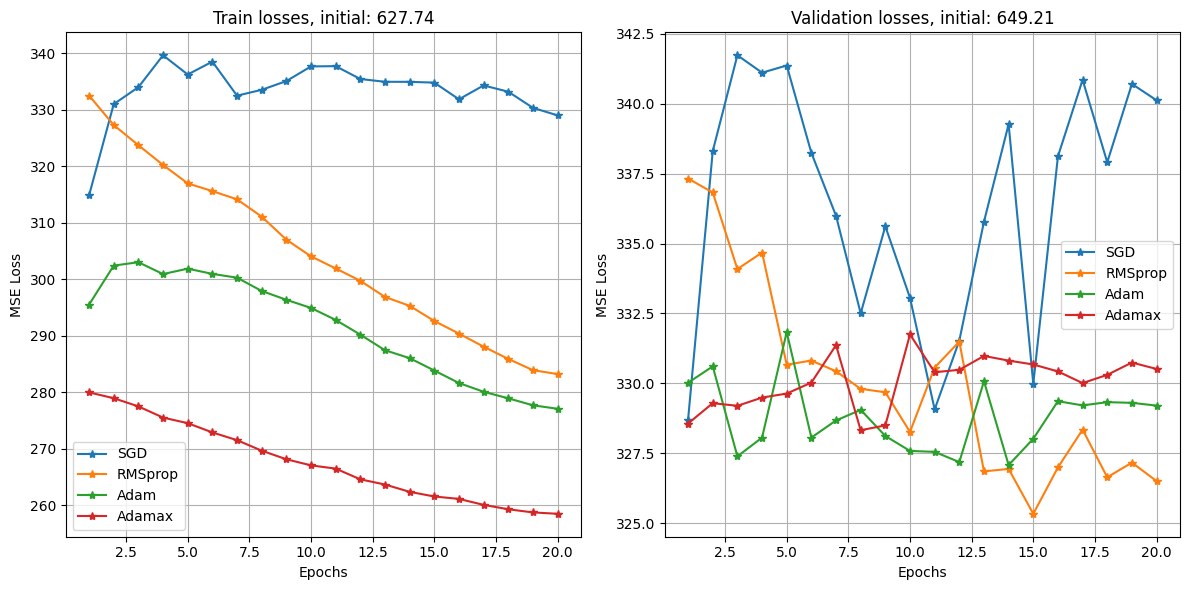

In [31]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_test.png",
)

### So for full training we will take Adam

In [8]:
# hyperparams for training
# df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.000563403
HIDDEN_LAYER = 26
HIDDEN_WIDTH = 84
# EXPERIMENT_NAME = "exp_put_5_final"
# MODEL_TYPE = AmericanPut_gated3
# experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
# os.makedirs(experiment_dir, exist_ok=True)

In [9]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [10]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )

In [13]:
# import torch.multiprocessing as mp
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
}
criteriation = nn.MSELoss()

In [14]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: RMSprop


100%|██████████| 63/63 [00:00<00:00, 267.71it/s]

Epoch 1, train loss: 291.7043, val loss: 283.4895



100%|██████████| 63/63 [00:00<00:00, 271.62it/s]

Epoch 2, train loss: 288.3290, val loss: 283.9966



100%|██████████| 63/63 [00:00<00:00, 272.25it/s]

Epoch 3, train loss: 287.1248, val loss: 288.7178



100%|██████████| 63/63 [00:00<00:00, 304.49it/s]

Epoch 4, train loss: 286.4773, val loss: 282.7420



100%|██████████| 63/63 [00:00<00:00, 294.35it/s]

Epoch 5, train loss: 286.1086, val loss: 287.0788



100%|██████████| 63/63 [00:00<00:00, 275.07it/s]

Epoch 6, train loss: 285.8408, val loss: 282.5899



100%|██████████| 63/63 [00:00<00:00, 268.08it/s]

Epoch 7, train loss: 286.1813, val loss: 282.9232



100%|██████████| 63/63 [00:00<00:00, 264.49it/s]

Epoch 8, train loss: 285.6758, val loss: 286.0070



100%|██████████| 63/63 [00:00<00:00, 289.70it/s]

Epoch 9, train loss: 285.1891, val loss: 283.4520



100%|██████████| 63/63 [00:00<00:00, 273.30it/s]

Epoch 10, train loss: 285.2169, val loss: 283.1314



100%|██████████| 63/63 [00:00<00:00, 286.49it/s]

Epoch 11, train loss: 285.0773, val loss: 287.6030



100%|██████████| 63/63 [00:00<00:00, 278.24it/s]

Epoch 12, train loss: 285.2969, val loss: 284.2457



100%|██████████| 63/63 [00:00<00:00, 298.87it/s]

Epoch 13, train loss: 285.1653, val loss: 284.7016



100%|██████████| 63/63 [00:00<00:00, 265.46it/s]

Epoch 14, train loss: 285.5153, val loss: 284.7354



100%|██████████| 63/63 [00:00<00:00, 268.68it/s]

Epoch 15, train loss: 284.9977, val loss: 283.1604



100%|██████████| 63/63 [00:00<00:00, 284.38it/s]

Epoch 16, train loss: 285.5063, val loss: 284.4567



100%|██████████| 63/63 [00:00<00:00, 287.85it/s]

Epoch 17, train loss: 284.8570, val loss: 285.2886



100%|██████████| 63/63 [00:00<00:00, 282.06it/s]

Epoch 18, train loss: 284.9496, val loss: 284.5039



100%|██████████| 63/63 [00:00<00:00, 302.73it/s]

Epoch 19, train loss: 284.7875, val loss: 283.7983



100%|██████████| 63/63 [00:00<00:00, 281.85it/s]

Epoch 20, train loss: 285.0246, val loss: 283.3273



100%|██████████| 63/63 [00:00<00:00, 292.55it/s]

Epoch 21, train loss: 284.9507, val loss: 282.5053



100%|██████████| 63/63 [00:00<00:00, 289.93it/s]

Epoch 22, train loss: 284.5768, val loss: 286.1909



100%|██████████| 63/63 [00:00<00:00, 297.63it/s]

Epoch 23, train loss: 284.9575, val loss: 283.4178



100%|██████████| 63/63 [00:00<00:00, 276.18it/s]

Epoch 24, train loss: 284.6381, val loss: 285.2404



100%|██████████| 63/63 [00:00<00:00, 302.66it/s]

Epoch 25, train loss: 284.5972, val loss: 282.8045



100%|██████████| 63/63 [00:00<00:00, 271.46it/s]

Epoch 26, train loss: 284.8442, val loss: 283.6101



100%|██████████| 63/63 [00:00<00:00, 273.24it/s]

Epoch 27, train loss: 284.5386, val loss: 284.3390



100%|██████████| 63/63 [00:00<00:00, 306.07it/s]

Epoch 28, train loss: 284.5893, val loss: 283.4372



100%|██████████| 63/63 [00:00<00:00, 289.36it/s]

Epoch 29, train loss: 284.7016, val loss: 284.0803



100%|██████████| 63/63 [00:00<00:00, 262.51it/s]

Epoch 30, train loss: 284.5812, val loss: 282.9096



100%|██████████| 63/63 [00:00<00:00, 298.81it/s]

Epoch 31, train loss: 284.4980, val loss: 283.0494



100%|██████████| 63/63 [00:00<00:00, 274.60it/s]

Epoch 32, train loss: 284.3937, val loss: 282.8783



100%|██████████| 63/63 [00:00<00:00, 300.92it/s]

Epoch 33, train loss: 284.3430, val loss: 283.2051



100%|██████████| 63/63 [00:00<00:00, 268.84it/s]

Epoch 34, train loss: 284.3749, val loss: 284.3448



100%|██████████| 63/63 [00:00<00:00, 274.51it/s]

Epoch 35, train loss: 284.2347, val loss: 283.8463



100%|██████████| 63/63 [00:00<00:00, 264.81it/s]

Epoch 36, train loss: 284.2850, val loss: 282.8606



100%|██████████| 63/63 [00:00<00:00, 297.81it/s]

Epoch 37, train loss: 284.2529, val loss: 283.5516



100%|██████████| 63/63 [00:00<00:00, 296.67it/s]

Epoch 38, train loss: 284.2899, val loss: 283.1052



100%|██████████| 63/63 [00:00<00:00, 285.53it/s]

Epoch 39, train loss: 284.0666, val loss: 282.9836



100%|██████████| 63/63 [00:00<00:00, 307.48it/s]

Epoch 40, train loss: 284.0653, val loss: 282.8917



100%|██████████| 63/63 [00:00<00:00, 284.58it/s]

Epoch 41, train loss: 284.0489, val loss: 283.4243



100%|██████████| 63/63 [00:00<00:00, 251.13it/s]

Epoch 42, train loss: 283.9885, val loss: 282.9823



100%|██████████| 63/63 [00:00<00:00, 233.32it/s]

Epoch 43, train loss: 283.9205, val loss: 283.3473



100%|██████████| 63/63 [00:00<00:00, 284.59it/s]

Epoch 44, train loss: 283.8655, val loss: 283.2490



100%|██████████| 63/63 [00:00<00:00, 287.94it/s]

Epoch 45, train loss: 283.9578, val loss: 283.1957



100%|██████████| 63/63 [00:00<00:00, 278.61it/s]

Epoch 46, train loss: 283.9074, val loss: 283.1223



100%|██████████| 63/63 [00:00<00:00, 304.71it/s]

Epoch 47, train loss: 283.8846, val loss: 283.1420



100%|██████████| 63/63 [00:00<00:00, 304.72it/s]

Epoch 48, train loss: 283.8700, val loss: 283.1987



100%|██████████| 63/63 [00:00<00:00, 306.04it/s]

Epoch 49, train loss: 283.8598, val loss: 283.5497



100%|██████████| 63/63 [00:00<00:00, 294.78it/s]

Epoch 50, train loss: 283.8274, val loss: 283.2321


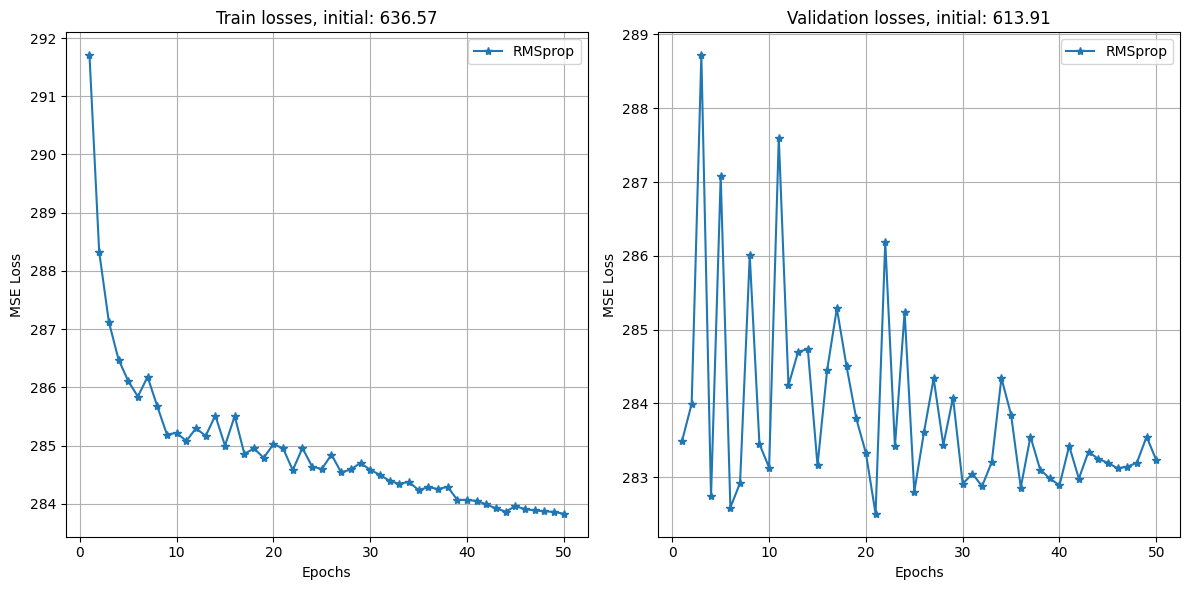

In [15]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [16]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [18]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['RMSprop'][40]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['RMSprop'][40] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)

In [29]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH, 100):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [30]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: Adam


100%|██████████| 698/698 [00:02<00:00, 346.55it/s]

Epoch 51, train loss: 15.1520, test loss: 15.0572



100%|██████████| 698/698 [00:02<00:00, 321.40it/s]

Epoch 52, train loss: 15.3887, test loss: 14.7960



100%|██████████| 698/698 [00:01<00:00, 350.77it/s]

Epoch 53, train loss: 15.1600, test loss: 15.0739



100%|██████████| 698/698 [00:01<00:00, 362.00it/s]

Epoch 54, train loss: 15.5402, test loss: 14.8740



100%|██████████| 698/698 [00:01<00:00, 357.46it/s]

Epoch 55, train loss: 15.3245, test loss: 14.9195



100%|██████████| 698/698 [00:01<00:00, 368.30it/s]

Epoch 56, train loss: 14.5784, test loss: 15.5519



100%|██████████| 698/698 [00:01<00:00, 362.18it/s]

Epoch 57, train loss: 14.6905, test loss: 15.2107



100%|██████████| 698/698 [00:01<00:00, 363.73it/s]

Epoch 58, train loss: 14.7698, test loss: 15.0287



100%|██████████| 698/698 [00:01<00:00, 366.32it/s]

Epoch 59, train loss: 14.6966, test loss: 14.9380



100%|██████████| 698/698 [00:01<00:00, 360.32it/s]

Epoch 60, train loss: 14.7310, test loss: 14.8965



100%|██████████| 698/698 [00:01<00:00, 367.51it/s]

Epoch 61, train loss: 15.1140, test loss: 14.9883



100%|██████████| 2791/2791 [00:20<00:00, 133.78it/s]

Epoch 00012: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 698/698 [00:02<00:00, 348.21it/s]

Epoch 62, train loss: 15.0032, test loss: 15.0009



100%|██████████| 698/698 [00:02<00:00, 333.69it/s]


Epoch 63, train loss: 13.9765, test loss: 14.9068


100%|██████████| 698/698 [00:01<00:00, 383.90it/s]

Epoch 64, train loss: 13.9467, test loss: 14.8981



100%|██████████| 698/698 [00:01<00:00, 386.41it/s]

Epoch 65, train loss: 13.9420, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 385.55it/s]

Epoch 66, train loss: 13.9126, test loss: 14.8817



100%|██████████| 698/698 [00:01<00:00, 383.74it/s]

Epoch 67, train loss: 13.9087, test loss: 14.8849



100%|██████████| 698/698 [00:01<00:00, 386.19it/s]

Epoch 68, train loss: 13.8657, test loss: 14.8844



100%|██████████| 698/698 [00:01<00:00, 381.88it/s]

Epoch 69, train loss: 13.8717, test loss: 14.8792



100%|██████████| 698/698 [00:01<00:00, 382.20it/s]

Epoch 70, train loss: 13.8497, test loss: 14.8795



100%|██████████| 698/698 [00:01<00:00, 376.96it/s]


Epoch 71, train loss: 13.8242, test loss: 14.8854


100%|██████████| 698/698 [00:01<00:00, 352.94it/s]

Epoch 72, train loss: 13.8136, test loss: 14.9072



100%|██████████| 698/698 [00:02<00:00, 341.90it/s]

Epoch 73, train loss: 13.8525, test loss: 14.8810



100%|██████████| 698/698 [00:02<00:00, 342.65it/s]

Epoch 74, train loss: 13.7920, test loss: 14.8710



100%|██████████| 698/698 [00:01<00:00, 356.31it/s]

Epoch 75, train loss: 13.8038, test loss: 14.8800



100%|██████████| 698/698 [00:01<00:00, 395.53it/s]

Epoch 76, train loss: 13.7929, test loss: 14.8801



100%|██████████| 698/698 [00:01<00:00, 409.48it/s]

Epoch 77, train loss: 13.7795, test loss: 14.8827



100%|██████████| 698/698 [00:01<00:00, 355.67it/s]

Epoch 78, train loss: 13.7519, test loss: 14.9581



100%|██████████| 698/698 [00:01<00:00, 358.27it/s]

Epoch 79, train loss: 13.7587, test loss: 14.8782



100%|██████████| 698/698 [00:02<00:00, 341.55it/s]

Epoch 80, train loss: 13.7785, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 353.28it/s]

Epoch 81, train loss: 13.7422, test loss: 14.8886



100%|██████████| 698/698 [00:01<00:00, 397.55it/s]

Epoch 82, train loss: 13.7631, test loss: 14.8928



100%|██████████| 698/698 [00:02<00:00, 336.77it/s]

Epoch 83, train loss: 13.7549, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 367.69it/s]

Epoch 84, train loss: 13.7512, test loss: 14.8932



100%|██████████| 698/698 [00:01<00:00, 352.76it/s]

Epoch 85, train loss: 13.7179, test loss: 14.8955



100%|██████████| 698/698 [00:01<00:00, 364.66it/s]

Epoch 86, train loss: 13.7321, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 359.67it/s]


Epoch 87, train loss: 13.7366, test loss: 14.8958


100%|██████████| 698/698 [00:01<00:00, 363.28it/s]

Epoch 88, train loss: 13.6819, test loss: 14.9143



100%|██████████| 698/698 [00:01<00:00, 379.32it/s]

Epoch 89, train loss: 13.6712, test loss: 14.9184



100%|██████████| 698/698 [00:01<00:00, 400.47it/s]

Epoch 90, train loss: 13.7265, test loss: 14.9111



100%|██████████| 698/698 [00:01<00:00, 424.63it/s]

Epoch 91, train loss: 13.6992, test loss: 14.9058



100%|██████████| 698/698 [00:01<00:00, 376.12it/s]

Epoch 92, train loss: 13.7273, test loss: 14.9105



100%|██████████| 698/698 [00:01<00:00, 371.47it/s]

Epoch 93, train loss: 13.6984, test loss: 14.9097



100%|██████████| 698/698 [00:01<00:00, 377.15it/s]


Epoch 94, train loss: 13.6989, test loss: 14.9163


100%|██████████| 2791/2791 [00:20<00:00, 137.37it/s]

Epoch 00045: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 698/698 [00:01<00:00, 349.47it/s]

Epoch 95, train loss: 13.7266, test loss: 14.9154



100%|██████████| 698/698 [00:01<00:00, 353.70it/s]

Epoch 96, train loss: 13.5943, test loss: 14.9160



100%|██████████| 698/698 [00:01<00:00, 388.76it/s]

Epoch 97, train loss: 13.5934, test loss: 14.9140



100%|██████████| 698/698 [00:01<00:00, 378.01it/s]

Epoch 98, train loss: 13.5931, test loss: 14.9152



100%|██████████| 698/698 [00:01<00:00, 369.65it/s]

Epoch 99, train loss: 13.5932, test loss: 14.9155



100%|██████████| 698/698 [00:01<00:00, 377.52it/s]

Epoch 100, train loss: 13.5906, test loss: 14.9126


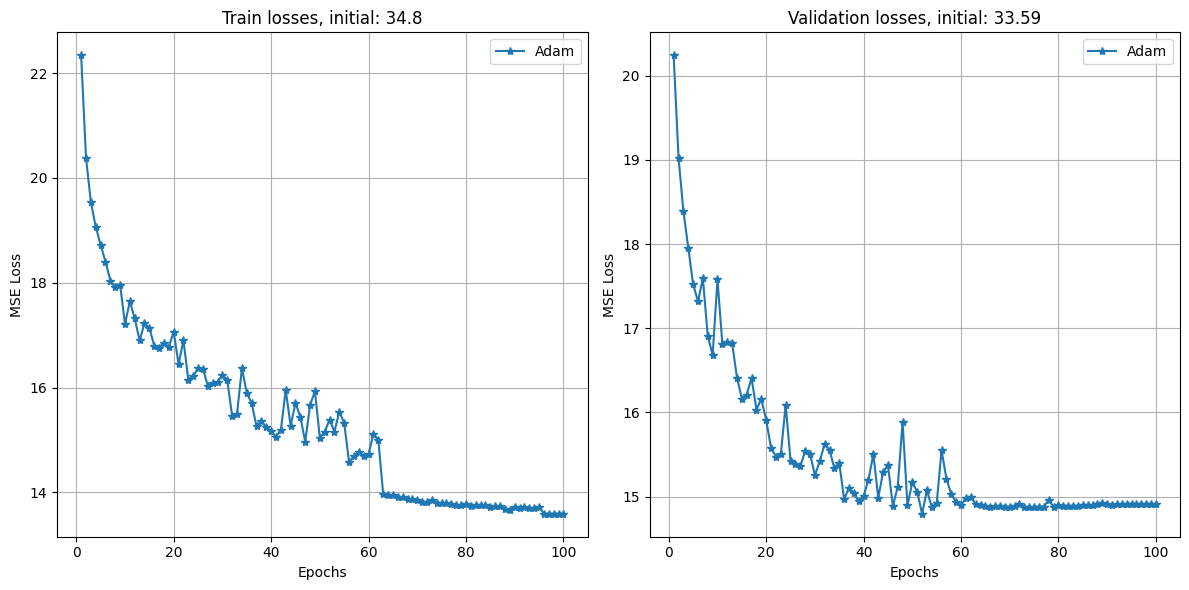

In [45]:
file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "r") as json_file:
    first_50_train = json.load(json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "r") as json_file:
    first_50_test = json.load(json_file)

train = np.concatenate((first_50_train["Adam"], train_loss_dict["Adam"]))
test = np.concatenate((first_50_test["Adam"], test_loss_dict["Adam"]))
train_all = {"Adam":train}
test_all = {"Adam":test}
plot_dictionaries(
    train_all,
    test_all,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [49]:
print(
    f"% of variation before training: {(initial_mse_train*100/(df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100/ (df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation before training: {(initial_mse_val*100/(df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100 / (df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)

% of variation before training: 108.54
% of variation after training: 47.15
% of variation before training: 108.57
% of variation after training: 48.85
